# Deacargar el Dataset 

In [2]:
!nvidia-smi

Tue Feb 15 02:47:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   31C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os, shutil, pathlib
import matplotlib.pyplot as plt

from tensorflow.keras.utils import image_dataset_from_directory

print (tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.6.2
Num GPUs Available:  1


In [4]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:',tf.test.gpu_device_name())
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [5]:
original_dir = pathlib.Path("../train")
new_base_dir = pathlib.Path("../cats_vs_dogs_small")

## Cargamos uno de los modelos

In [6]:
from tensorflow import keras
model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0     

## Una de las imágenes

In [7]:
from tensorflow import keras
import numpy as np

img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

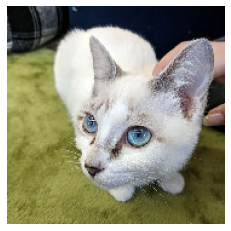

In [8]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

## inicializamos un modelo que devuelve las activaciones de las capas

In [9]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

In [10]:
activation_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0     

## usamos el modelo para obtener las activaciones en las capas

In [11]:
activations = activation_model.predict(img_tensor)

In [12]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


### Visualicemos el canal 5

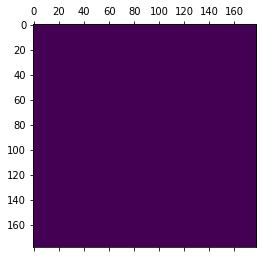

In [13]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

## Todos los canales y activaciones intermedias

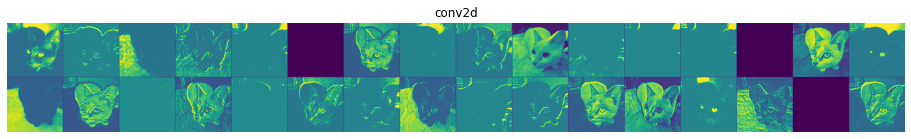

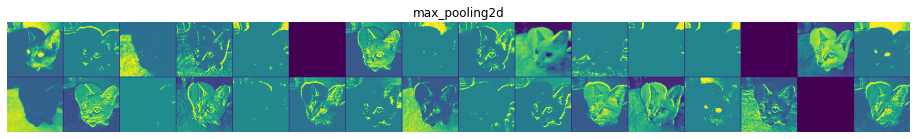

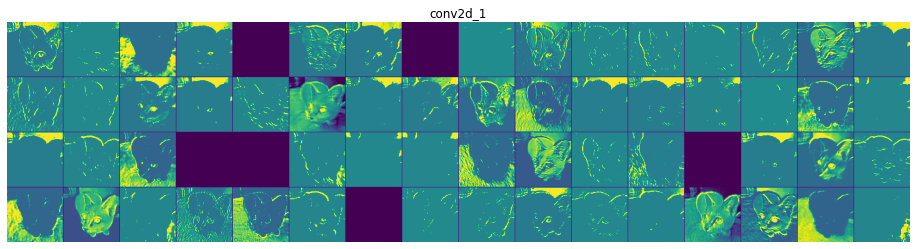

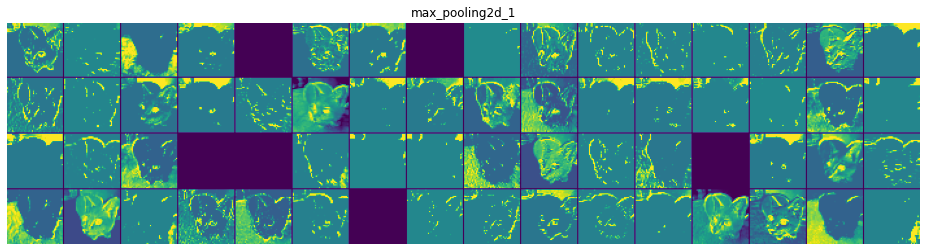

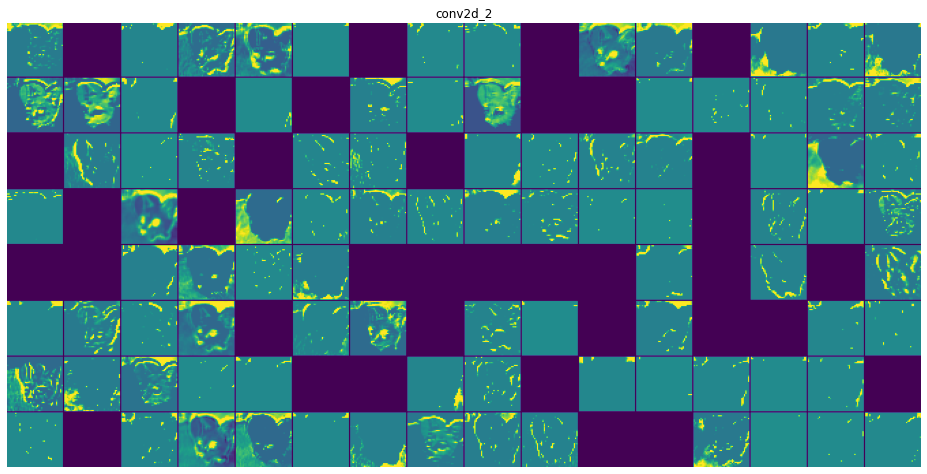

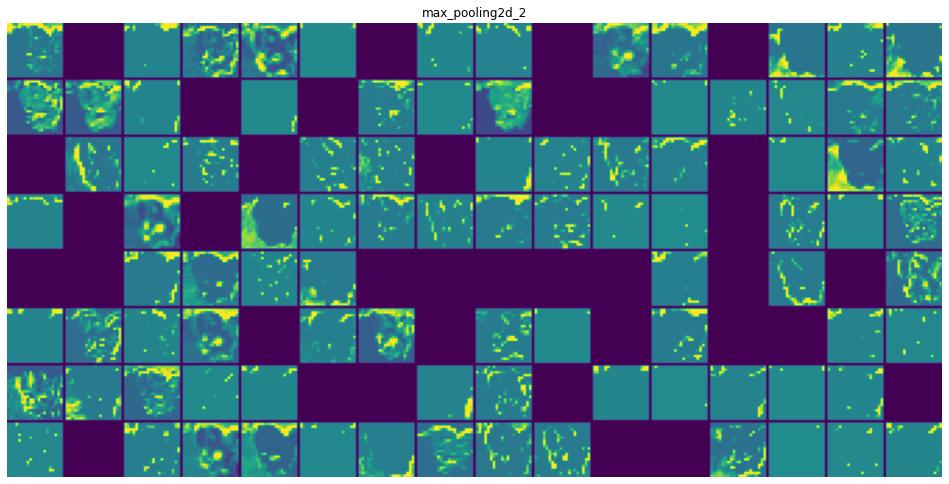

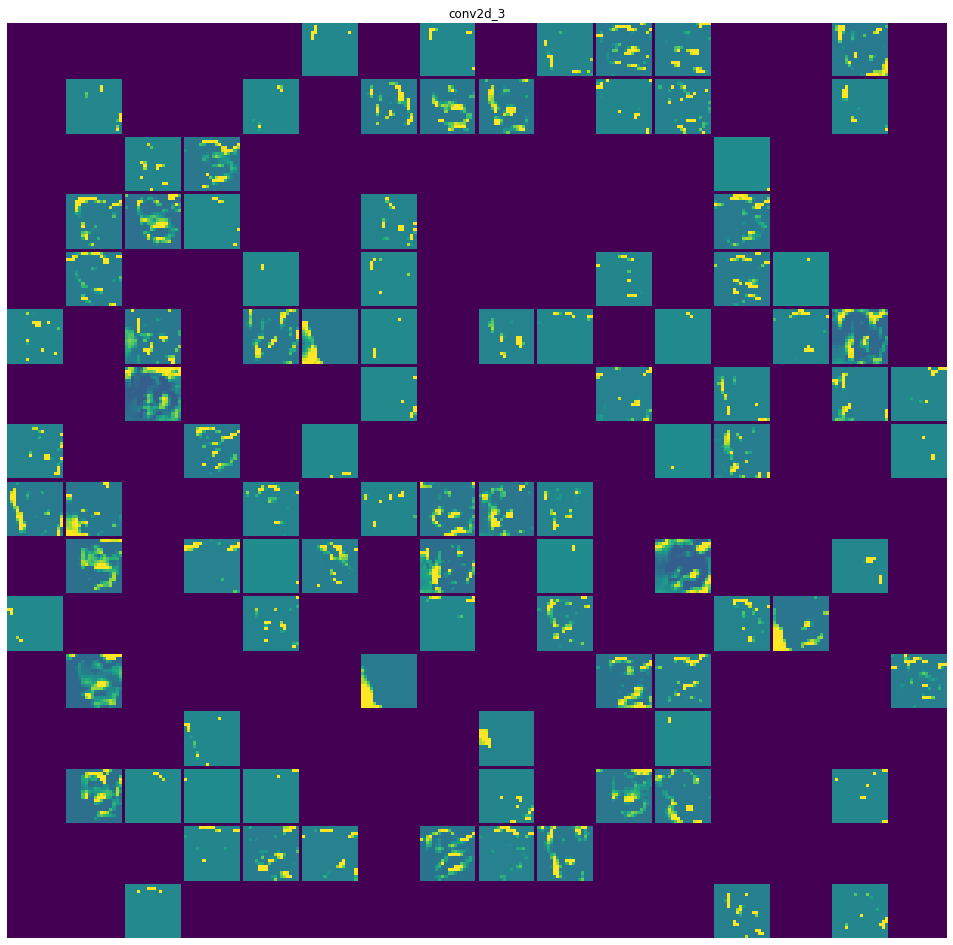

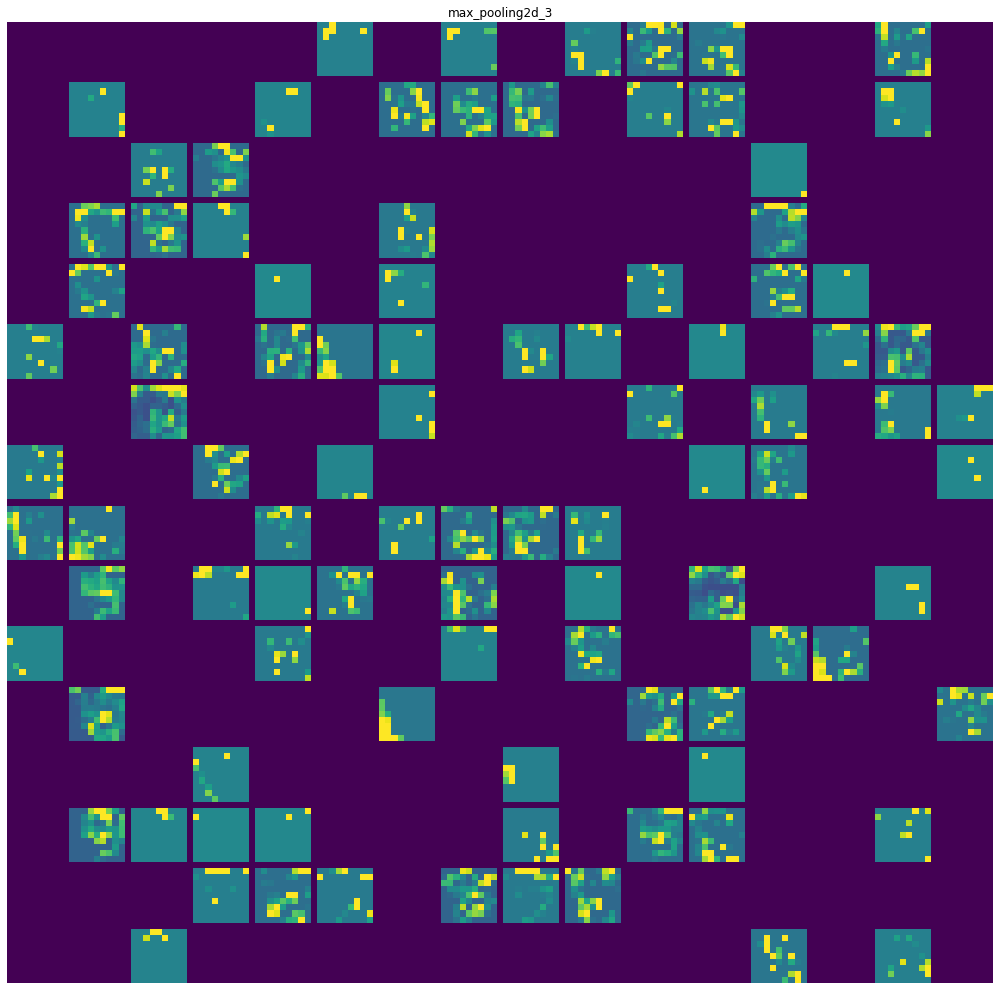

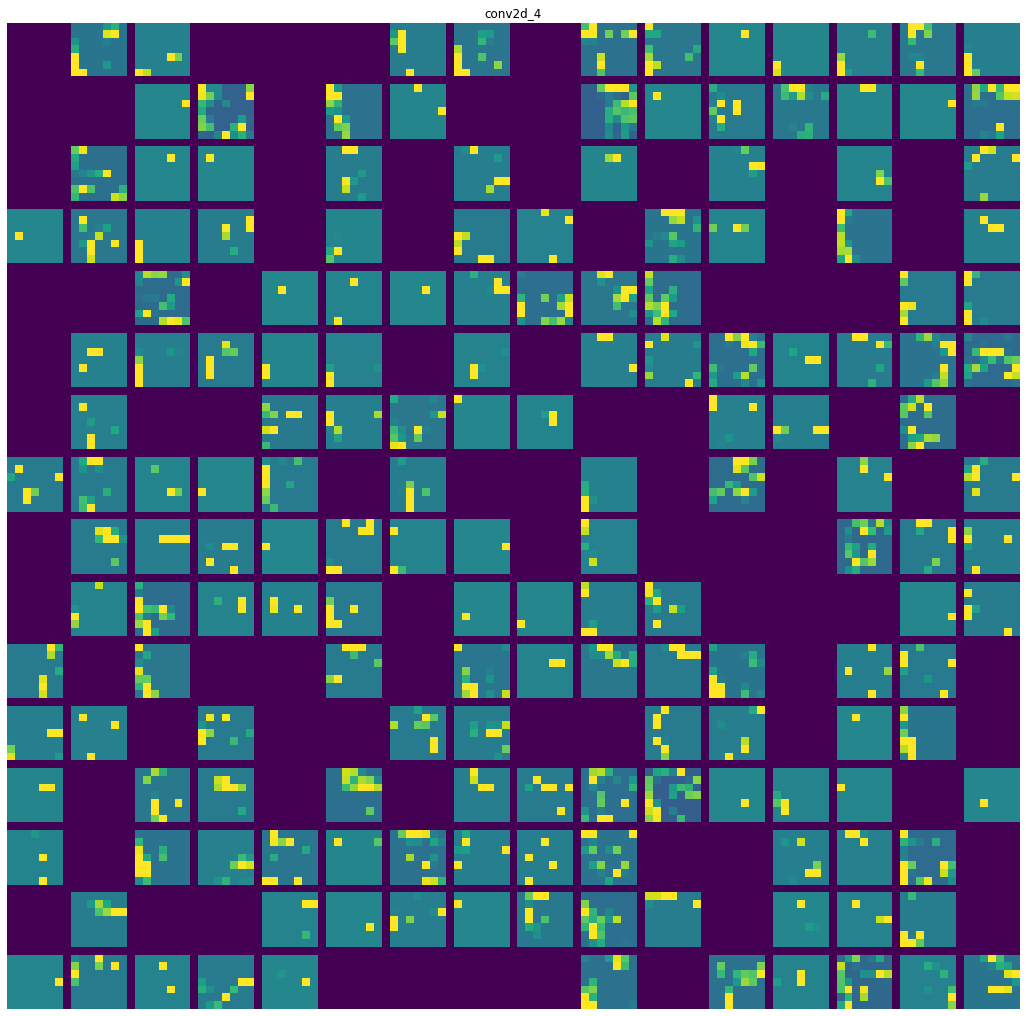

In [14]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

## Visualizando los filtros convolucionales
### Inicializando un modelo convolucional base Xception

In [15]:
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False)

83697664/83683744 [==============================] - 2s 0us/step


### Los nombres de todas las capas convolucionales

In [16]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


**Creating a "feature extractor" model that returns the output of a specific layer**

In [17]:
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

In [18]:
import tensorflow as tf

def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

**Loss maximization via stochastic gradient ascent**

In [19]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

**Funcion que genera las visualizaciones de los filtros**

In [21]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()


def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

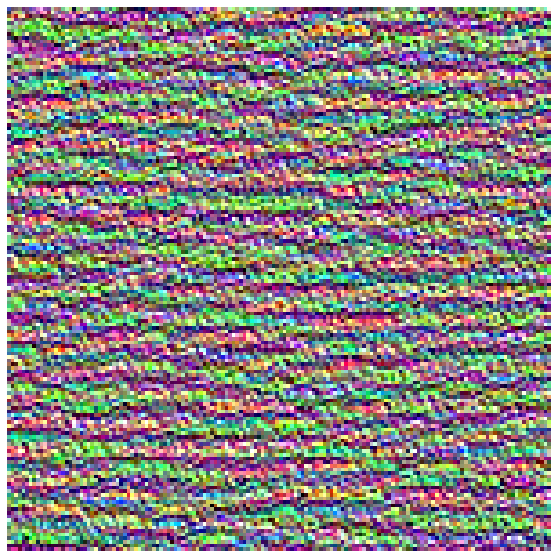

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis("off")
ax.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

**Generating a grid of all filter response patterns in a layer**

In [27]:
all_images = []
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

## Visualizando Heatmaps de activaciones de Clases

In [28]:
model = keras.applications.xception.Xception(weights="imagenet")

91897856/91884032 [==============================] - 2s 0us/step


In [29]:
img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

745472/733657 [==============================] - 0s 0us/step


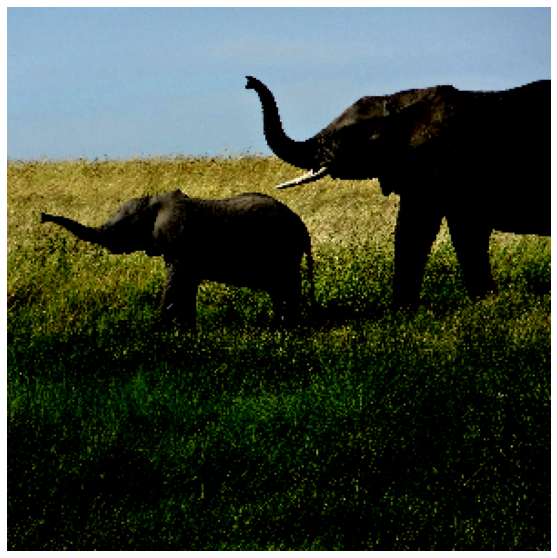

In [37]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis("off")
ax.imshow(img_array[0])


In [30]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

49152/35363 [=========================================] - 0s 0us/step
[('n02504458', 'African_elephant', 0.8699264), ('n01871265', 'tusker', 0.076968774), ('n02504013', 'Indian_elephant', 0.023537323)]


In [38]:
np.argmax(preds[0])

386

### Un modelo que devuelve el último output convolucional

In [40]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

**Setting up a model that goes from the last convolutional output to the final predictions**

In [41]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

**Retrieving the gradients of the top predicted class with regard to the last convolutional output**

In [42]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

**Gradient pooling and channel importance weighting**

In [43]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

**Heatmap post-processing**

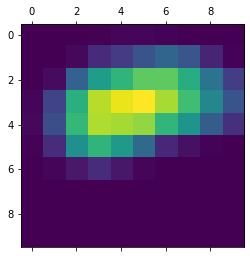

In [44]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

**Superimposing the heatmap with the original picture**

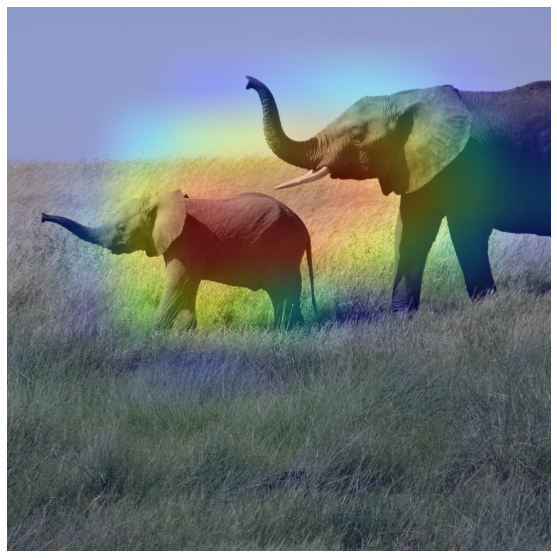

In [47]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis("off")

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img


superimposed_img = keras.utils.array_to_img(superimposed_img)
ax.imshow(superimposed_img)
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)